<a href="https://colab.research.google.com/github/mgalusza/Notebooks/blob/master/graphSAGE_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [51]:
cd /content/gdrive/My Drive/ML


/content/gdrive/My Drive/ML


In [54]:
ls -la

total 7720
-rw------- 1 root root   69928 Feb 18  2007 cora.cites
-rw------- 1 root root 7823427 Feb 18  2007 cora.content
-rw------- 1 root root    5097 Nov 10 18:29 Dam_Edge_List.csv
-rw------- 1 root root    3120 Nov 10 19:46 Dam_Node_Word.csv
-rw------- 1 root root    1560 Feb 18  2007 README


In [3]:
!pip install stellargraph

     |████████████████████████████████| 153kB 10.2MB/s 
     |████████████████████████████████| 1.8MB 38.6MB/s 
     |████████████████████████████████| 109.2MB 92kB/s 
     |████████████████████████████████| 3.2MB 35.8MB/s 
     |████████████████████████████████| 491kB 52.0MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556408 sha256=d59279e68265b5212a9ed24b393f378985e846c38b1f906bc44e2ad79fe14c93
  Stored in directory: /root/.cache/pip/wheels/de/63/64/3699be2a9d0ccdb37c7f16329acf3863fd76eda58c39c737af
Successfully built networkx
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: networkx 2.4
    Uninstalling networkx-2.4:
      Successfully uninstalled networkx-2.4
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 

In [0]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

In [65]:
data_dir = os.path.expanduser("")
g_pd = pd.read_csv("Dam_Edge_List.csv",delimiter = ",")
print(g_pd)

     source  target  weight
0         0       1     1.0
1         1     301     1.0
2         2       3     1.0
3         3     264     1.0
4         4       5     1.0
..      ...     ...     ...
424     509     510     1.0
425     510     507     1.0
426     511     411     1.0
427     512       0     1.0
428     512       4     1.0

[429 rows x 3 columns]


In [72]:
g_nx = nx.from_pandas_edgelist(g_pd,source='source', target='target',edge_attr='weight')


# load the node attribute data
cora_data_location = os.path.expanduser(os.path.join(data_dir, "Dam_Node_Word.csv"))
node_attr = pd.read_csv(cora_data_location, sep=',', header=0)
values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
nx.set_node_attributes(g_nx, values, 'lemma')

# Select the largest connected component. For clarity we ignore isolated
# nodes and subgraphs; having these in the data does not prevent the
# algorithm from running and producing valid results.
g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
g_nx = max(g_nx_ccs, key=len)
print("Largest subgraph statistics: {} nodes, {} edges".format(
    g_nx.number_of_nodes(), g_nx.number_of_edges()))

Largest subgraph statistics: 283 nodes, 424 edges


In [73]:
node_attr

,ID(n),n.lemma
0,0,fall
1,1,wall
2,2,40
3,3,%
4,4,lose
...,...,...
278,508,grow
279,509,attempt
280,510,fill
281,511,dam


In [0]:
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_table(os.path.join(data_dir, "cora.content"), header=None, names=column_names)

In [0]:
node_data.index = node_data.index.map(str)
node_data = node_data[node_data.index.isin(list(g_nx.nodes()))]

In [0]:
set(node_data["subject"])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

In [0]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=0.1, test_size=None, stratify=node_data['subject'], random_state=42)

from collections import Counter
Counter(train_data['subject'])

Counter({'Case_Based': 28,
         'Genetic_Algorithms': 41,
         'Neural_Networks': 73,
         'Probabilistic_Methods': 38,
         'Reinforcement_Learning': 21,
         'Rule_Learning': 13,
         'Theory': 34})

In [0]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

In [0]:
node_features = node_data[feature_names]

In [0]:
node_features.head()

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,...,w_1393,w_1394,w_1395,w_1396,w_1397,w_1398,w_1399,w_1400,w_1401,w_1402,w_1403,w_1404,w_1405,w_1406,w_1407,w_1408,w_1409,w_1410,w_1411,w_1412,w_1413,w_1414,w_1415,w_1416,w_1417,w_1418,w_1419,w_1420,w_1421,w_1422,w_1423,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432
31336,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1061127,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1106406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
G = sg.StellarGraph(g_nx, node_features=node_features)

In [0]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5069

 Node types:
  default: [2485]
        Attributes: {'subject'}
    Edge types: default-default->default

 Edge types:
    default-default->default: [5069]



In [0]:
batch_size = 50; num_samples = [10, 10]

In [0]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

In [0]:
train_gen = generator.flow(train_data.index, train_targets)

In [0]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32],
    generator=train_gen,
    bias=True,
    dropout=0.5,
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
x_inp, x_out = graphsage_model.default_model(flatten_output=True)
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [0]:
prediction.shape

TensorShape([Dimension(None), Dimension(7)])

In [0]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [0]:
test_gen = generator.flow(test_data.index, test_targets)

In [0]:
history = model.fit_generator(
    train_gen,
    epochs=20,
    validation_data=test_gen,
    verbose=2,
    shuffle=True,
)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
5/5 - 4s - loss: 1.8676 - acc: 0.2500 - val_loss: 1.7343 - val_acc: 0.3590
Epoch 2/20
5/5 - 3s - loss: 1.6937 - acc: 0.4194 - val_loss: 1.6119 - val_acc: 0.4542
Epoch 3/20
5/5 - 3s - loss: 1.5490 - acc: 0.5766 - val_loss: 1.4768 - val_acc: 0.5793
Epoch 4/20
5/5 - 3s - loss: 1.3902 - acc: 0.7339 - val_loss: 1.3574 - val_acc: 0.7184
Epoch 5/20
5/5 - 3s - loss: 1.2805 - acc: 0.8024 - val_loss: 1.2567 - val_acc: 0.7662
Epoch 6/20
5/5 - 3s - loss: 1.1553 - acc: 0.8750 - val_loss: 1.1750 - val_acc: 0.7814
Epoch 7/20
5/5 - 3s - loss: 1.0477 - acc: 0.8992 - val_loss: 1.0881 - val_acc: 0.7997
Epoch 8/20
5/5 - 3s - loss: 0.9404 - acc: 0.9355 - val_loss: 1.0166 - val_acc: 0.8163
Epoch 9/20
5/5 - 3s - loss: 0.8622 - acc: 0.9516 - val_loss: 0.9642 - val_acc: 0.8149
Epoch 10/20
5/5 - 3s - loss: 0.7827 - acc: 0.9637 - val_loss: 0.9078 - val_acc: 0.8257
Epoch 11/20
5/5 - 3s - loss: 0.7128 - acc: 0.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')
        plt.show()

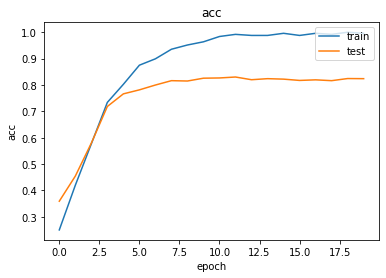

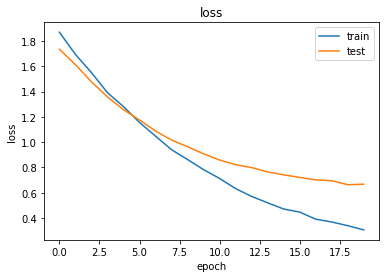

In [0]:
plot_history(history)

In [0]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.6589
	acc: 0.8207


In [0]:
all_nodes = node_data.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict_generator(all_mapper)

In [0]:
node_predictions = target_encoding.inverse_transform(all_predictions)

In [0]:
results = pd.DataFrame(node_predictions, index=all_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data['subject']})
df.head(10)

,Predicted,True
31336,subject=Theory,Neural_Networks
1061127,subject=Rule_Learning,Rule_Learning
1106406,subject=Reinforcement_Learning,Reinforcement_Learning
13195,subject=Reinforcement_Learning,Reinforcement_Learning
37879,subject=Probabilistic_Methods,Probabilistic_Methods
1126012,subject=Probabilistic_Methods,Probabilistic_Methods
1107140,subject=Theory,Theory
1102850,subject=Theory,Neural_Networks
31349,subject=Theory,Neural_Networks
1106418,subject=Theory,Theory
